In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

#intrinsic params
focal = 910
width = 1164
height = 874
center_x = width/2
center_y = height/2
dir = "0"
start_frame = 0
end_frame = 100 #note, when dir 4, change to 1195
total_frames = 1200 if(int(dir) != 4) else 1196


whole_video = True # for submission purposes, adds results for the last frame to make sure array is the correct size.
train = True if (int(dir) <= 4) else False # for plotting purposes later. True if it is in the train set and has ground truth labels


# Intrinsic Camera Matrix
K = np.array([[focal, 0    , center_x],
              [0    , focal, center_y],
              [0    , 0    , 1       ]])


'''
Reads and returns image frame using OpenCV given its respective video and frame number
'''
def read_specific_frame(video_directory, frame_number):
    frame_path = f"./{video_directory}/{frame_number}.jpg"

    # Check if the frame exists
    if not os.path.exists(frame_path):
        print(f"Frame {frame_number} does not exist in the directory.")
        return None

    frame = cv2.imread(frame_path)

    return frame

'''
Returns window to use for calculating the moving average of data in the dataset
'''

def getWindow(index, window_size):
    numLeft = window_size//2
    numRight = window_size//2

    if(index - numLeft <= 0):
        return 0, window_size
    if(index + numRight > end_frame-start_frame):
        return end_frame-start_frame-window_size, end_frame-start_frame
    return index-numLeft, index+numRight

'''
Creates a mask of all pixels that are completely black. 
Images have been preprocessed to crop out cars and the front hood as they mess up Essential Matrix calculations.
'''
def create_black_pixel_mask(image, threshold=0):
    black_pixels = (image == 0)
    kernel = np.ones((threshold*2+1, threshold*2+1), np.uint8)
    mask = cv2.dilate(black_pixels.astype(np.uint8), kernel, iterations=1)
    return mask


'''
Checks if pixel is within a mask that is inputted
'''
def is_near_black_pixel(point, mask):
    x, y = int(point[0]), int(point[1])
    return mask[y, x] == 1
'''
Calculates Epipole location in image from a given fundamental matrix
'''
def calculateEpipole(F):
    U, S, Vt = cv2.SVDecomp(F)

    epipole = Vt.T[:, -1]

    epipole = epipole / epipole[-1]

    epipole_x, epipole_y = int(epipole[0]), int(epipole[1])

    return epipole_x, epipole_y


In [2]:
sift = cv2.SIFT_create(contrastThreshold = 0.01, edgeThreshold=100, sigma=1.6)
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
yaw_values = []
pitch_values = []


first_frame = read_specific_frame(dir, 0)
first_gray  = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
keypoints, descriptors = sift.detectAndCompute(first_gray, None)

second_matches = (keypoints, descriptors)
for i in range(start_frame, end_frame):
    frame1 = read_specific_frame(dir, i)
    frame2 = read_specific_frame(dir, i+1)
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    mask1 = create_black_pixel_mask(gray1)
    mask2 = create_black_pixel_mask(gray2)

    keypoints1, descriptors1 = second_matches
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)
    second_matches = (keypoints2, descriptors2)

    matches = bf.knnMatch(descriptors1,descriptors2,k=2)

    #lowes ratio
    filtered_matches = []
    ratio_thresh = 0.75
    for m,n in matches:
        if m.distance < ratio_thresh * n.distance:
            filtered_matches.append([m])
    matches = filtered_matches

    #filter based on preprocessed mask, no moving cars and car hood
    filtered_matches = []
    for m in matches:
        m = m[0]
        pt1 = keypoints1[m.queryIdx].pt
        pt2 = keypoints2[m.trainIdx].pt

        (x1, y1) = pt1
        (x2, y2) = pt2

        if not (is_near_black_pixel(pt1, mask1) or is_near_black_pixel(pt2, mask2)):
            filtered_matches.append(m)
    matches = filtered_matches

    pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

    E, mask = cv2.findEssentialMat(pts1, pts2, K, cv2.RANSAC, prob=0.99999, threshold=0.5)
    F = np.linalg.inv(K).T @ E @ np.linalg.inv(K)

    if F is None:
        yaw_values.append(yaw)
        pitch_values.append(pitch)
        continue

    epipole_x, epipole_y = calculateEpipole(F)
    
    yaw = np.arctan((epipole_x - center_x) / focal)
    pitch = np.arctan((center_y - epipole_y) / focal)

    yaw_values.append(yaw)
    pitch_values.append(pitch)
if(whole_video):
    while(end_frame < total_frames):
        yaw_values.append(yaw)
        pitch_values.append(pitch)
        end_frame += 1


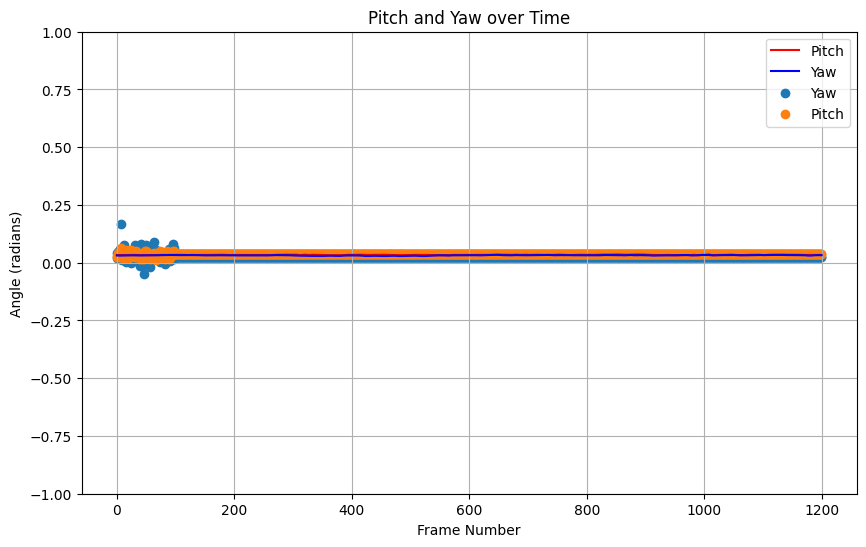

In [3]:
#view data pre moving average
if(train):
    data = pd.read_csv('../labeled/'+dir+'.txt', sep=' ', header=None, names=['pitch', 'yaw'])
    data = data.iloc[start_frame:end_frame]

plt.figure(figsize=(10,6))
if(train):
    plt.plot(data['pitch'], label='Pitch', color="red")
    plt.plot(data['yaw'], label='Yaw',color="blue")

plt.scatter(range(start_frame,end_frame), yaw_values, label='Yaw')
plt.scatter(range(start_frame,end_frame), pitch_values, label='Pitch')
plt.xlabel('Frame Number')
plt.ylabel('Angle (radians)')
plt.title('Pitch and Yaw over Time')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True)
plt.show()


In [4]:
#moving average on data, remove outliers
window_size = 30

clipped_yaw_values  = []
clipped_pitch_values = []

for i in range(end_frame - start_frame):

    window_start, window_end = getWindow(i,window_size)
    yaw_window_values = yaw_values[window_start:window_end]
    pitch_window_values =  pitch_values[window_start:window_end]

    yaw_window_values = sorted(yaw_window_values)
    pitch_window_values = sorted(pitch_window_values)
    yaw_middle_values = yaw_window_values[window_size//3 - 2:window_size//2 + 3]
    pitch_middle_values = pitch_window_values[window_size//3 - 2:window_size//2 + 3] 
    yaw_window_mean = np.mean(yaw_middle_values)
    pitch_window_mean = np.mean(pitch_middle_values)

    yaw_val = yaw_values[i]
    pitch_val = pitch_values[i]

    if yaw_val < (yaw_window_mean - yaw_window_mean/2):
        clipped_yaw_values.append(yaw_window_mean)
    elif yaw_val > (yaw_window_mean + yaw_window_mean/2):
        clipped_yaw_values.append(yaw_window_mean)
    else:
        clipped_yaw_values.append(yaw_val)

    if pitch_val < (pitch_window_mean - pitch_window_mean/2):
        clipped_pitch_values.append(pitch_window_mean)
    elif pitch_val > (pitch_window_mean + pitch_window_mean/2):
        clipped_pitch_values.append(pitch_window_mean)
    else:
        clipped_pitch_values.append(pitch_val)
    

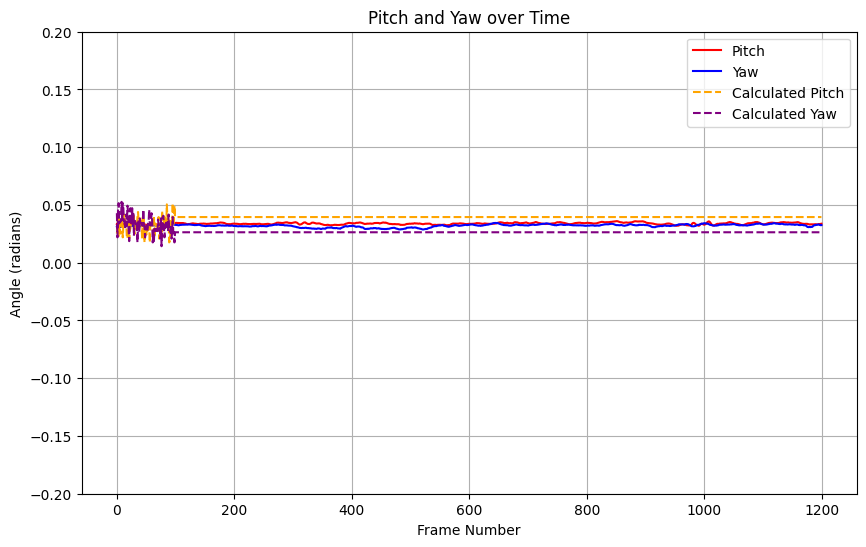

In [5]:
if(train):
    data = pd.read_csv('../labeled/'+dir+'.txt', sep=' ', header=None, names=['pitch', 'yaw'])
    data = data.iloc[start_frame:end_frame]

# Plotting
plt.figure(figsize=(10,6))
if(train):
    plt.plot(data['pitch'], label='Pitch', color="red")
    plt.plot(data['yaw'], label='Yaw',color="blue")


plt.plot(range(start_frame,end_frame), clipped_pitch_values, label='Calculated Pitch', linestyle='--', color='orange')
plt.plot(range(start_frame,end_frame), clipped_yaw_values, label='Calculated Yaw', linestyle='--', color='purple')
plt.xlabel('Frame Number')
plt.ylabel('Angle (radians)')
plt.title('Pitch and Yaw over Time')
plt.ylim(-0.2, 0.2) 

plt.legend()
plt.grid(True)
plt.show()

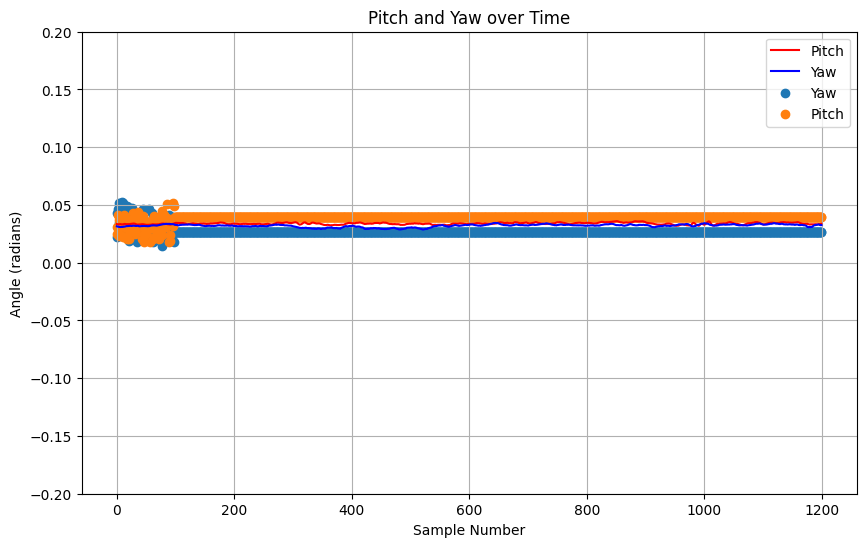

In [6]:
if(train):
    data = pd.read_csv('../labeled/'+dir+'.txt', sep=' ', header=None, names=['pitch', 'yaw'])
    data = data.iloc[start_frame:end_frame]

plt.figure(figsize=(10,6))
if(train):
    plt.plot(data['pitch'], label='Pitch', color="red")
    plt.plot(data['yaw'], label='Yaw',color="blue")

plt.scatter(range(start_frame, end_frame), clipped_yaw_values, label='Yaw')
plt.scatter(range(start_frame, end_frame), clipped_pitch_values, label='Pitch')
plt.xlabel('Sample Number')
plt.ylabel('Angle (radians)')
plt.title('Pitch and Yaw over Time')
plt.ylim(-0.2,0.2)

plt.legend()
plt.grid(True)
plt.show()

In [7]:
data = pd.read_csv('../labeled/'+dir+'.txt', sep=' ', header=None, names=['pitch', 'yaw'])
data = data.iloc[start_frame:end_frame]


clipped_pitch_values = clipped_pitch_values
clipped_yaw_values = clipped_yaw_values
def get_mse(gt, test):
  test = np.nan_to_num(test)
  return np.mean(np.nanmean((gt - test)**2, axis=0))

zero_mses = []
mses = []

zero_mses.append(get_mse(data, np.zeros_like(data)))

mses.append(get_mse(data, np.array([clipped_pitch_values,clipped_yaw_values]).T))

percent_err_vs_all_zeros = 100*np.mean(mses)/np.mean(zero_mses)
print(f'YOUR ERROR SCORE IS {percent_err_vs_all_zeros:.2f}% (lower is better)')


YOUR ERROR SCORE IS 3.20% (lower is better)


In [370]:
#save results
arraysaving = np.array([clipped_pitch_values,clipped_yaw_values]).T
np.savetxt("unlabeled_output_final/"+dir+".txt", arraysaving, fmt='%f', delimiter=' ')